In [1]:
from functools import reduce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [17]:
# Initialize to avoid load error, set
# actual values at execution step.
YEARS = []  
OFFICES = []


def removeUncommonColumns(nested_dict):
    print("Removing uncommon columns...")
    
    # Flatten and find common columns
    all_dfs = [df for year in nested_dict for df in nested_dict[year].values()]
    common_cols = set(all_dfs[0].columns)
    for df in all_dfs[1:]:
        common_cols &= set(df.columns)
    
    # Safely trim all dataframes
    for year in nested_dict:
        for office in nested_dict[year]:
            df = nested_dict[year][office]
            existing_cols = [col for col in common_cols if col in df.columns]
            nested_dict[year][office] = df[existing_cols]

    print('Done.')
    
    return nested_dict


def makeDatasets(years, offices, remove_xtra_cols=False):
    print('Making datasets...')
    
    df_datasets = {}
    
    for year in years:
        print(f'Processing year {year}...')
        df_datasets[year] = {}
        
        for office in offices:
            print(f'Processing office {office}...')

            df = pd.read_csv('data/generated_data/07_ml_features_' + year + '_' + office + '.csv', low_memory=False)

            for col in df.columns:
                if col.startswith(('S', 'B', 'D')):
                    invalid_values = ['(X)', '-', 'N/A', 'null', '']
                    df[col] = df[col].replace(invalid_values, np.nan)
            
            # For running this function separately
            # on other years and offices outside of
            # the main execution loop.
            # For example, 2024 has columns that other
            # years do not, which causes errors.
            if remove_xtra_cols:
                df = df.drop(columns=remove_xtra_cols, errors='ignore')

            df_datasets[year][office] = df
    
    # df_datasets = removeUncommonColumns(df_datasets)

    print('Done.')
    
    return df_datasets


def makeFeaturesTargets(df):
    print(f'Making features and target...')
    
    y = df[['partisan_temp']]
    X = df.drop(columns=['standardized_id_num', 'partisan_temp', 'partisan_temp_change_curr'])

    # Remove useless features
    # For reference: 'dem_share_change_prev', 'rep_share_change_prev', 'oth_share_change_prev' have HUGE pred. power
    X = X.drop(columns=[
        # 'dem_share_prev', 'rep_share_prev', 'oth_share_prev', 
        # 'dem_votes_change_prev', 'rep_votes_change_prev', 'oth_votes_change_prev',
        # 'dem_share_change_prev', 'rep_share_change_prev', 'oth_share_change_prev',
        # 'dem_share_change_prev', 'oth_share_change_prev',
        # 'partisan_temp_change_prev', 'turnout_pct_change_prev',
    ])

    print('Done.')
    
    return X, y


def fitModel(X, y):
    print(f'Fitting model...')
    
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # or 'median'
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    print('Done.')

    return model, X_train, X_test, y_train, y_test, numeric_cols


def makePredictions(X_test, model):
    print(f'Making predictions...')
    y_pred = model.predict(X_test)
    print('Done.')
    return y_pred


def plotAccuracy(y_test, y_pred):
    print(f'Plotting accuracy...')
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Prediction Accuracy")
    plt.grid(True)
    print('Done.')
    return plt


def featureCoeff(model):
    print(f'Computing feature coefficients...')
    sort_column = 'coefficient'
    coefficients = model.named_steps['regressor'].coef_.flatten()
    feature_names = get_feature_names(model)
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values(by='abs_coefficient', ascending=False)

    top_features = coef_df[coef_df['coefficient'] > 0].sort_values(by='coefficient', ascending=False).head(TOP_N_FEATURES)
    print('Done.')
    return top_features


def plotFeatureCoeff(top_features):
    print(f'Plotting feature coefficients...')
    plt.figure(figsize=(12, 7))
    bars = plt.barh(top_features['feature'], top_features['coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {TOP_N_FEATURES} Most Influential Features (Linear Regression)')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.grid(True, axis='x', linestyle=':', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    print('Done.')
    return plt


def get_feature_names(model):
    print("Getting feature names...")

    preprocessor = model.named_steps['preprocessor']

    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        # Manual fallback
        feature_names = []
        for name, trans, cols in preprocessor.transformers_:
            if trans == 'drop' or trans is None:
                continue
            if isinstance(trans, Pipeline):
                last_step = trans.steps[-1][1]
                if hasattr(last_step, 'get_feature_names_out'):
                    feature_names.extend(last_step.get_feature_names_out(cols))
                else:
                    feature_names.extend(cols)
            elif hasattr(trans, 'get_feature_names_out'):
                feature_names.extend(trans.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)

    print(f"Done. Retrieved {len(feature_names)} feature names.")
    return feature_names


def mergeTopFeatures(top_features_lists):
    print(f'Creating common top features...')
    
    from itertools import chain

    # Features found in all lists
    common_features = set(top_features_lists[0])
    for feature_list in top_features_lists[1:]:
        common_features.intersection_update(feature_list)

    # Preserve item order
    seen = set()
    merged_common_ordered = []

    for item in chain.from_iterable(top_features_lists):
        if item in common_features and item not in seen:
            seen.add(item)
            merged_common_ordered.append(item)

    print('Done.')
    
    return merged_common_ordered

#### Execution

In [18]:
YEARS = ['2018', '2020', '2022']
OFFICES = ['US_House']
TOP_N_FEATURES = 100

census_datasets = [
    'b02001_race', 'b04007_ancestry', 'b05012_nativity_us', 'b08303_travel_time_work', 'b25003_housing_rentership', 
    'dp02_selected_social_characteristics', 'dp03_selected_economic_characteristics', 'dp04_housing_characteristics', 'dp05_age_race', 
    's0101_age_sex', 's1101_households_families', 's1201_marital_status', 's1501_educational_attainment', 's1701_income_poverty', 
    's1903_median_income', 's2101_veteran_status', 's2201_food_stamps', 's2301_employment_status', 's2401_occupation_sex', 
    's2403_industry_sex', 's2501_occupancy_characteristics', 's2701_health_insurance', 's2503_financial_characteristics',
]

#### Feature Analysis

Making datasets...
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Done.
Processing year 2018...
Processing office US_House...
Making features and target...
Done.
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 1138856959913705.2
R2 Score: -5271431848405215.0
Plotting accuracy...
Done.


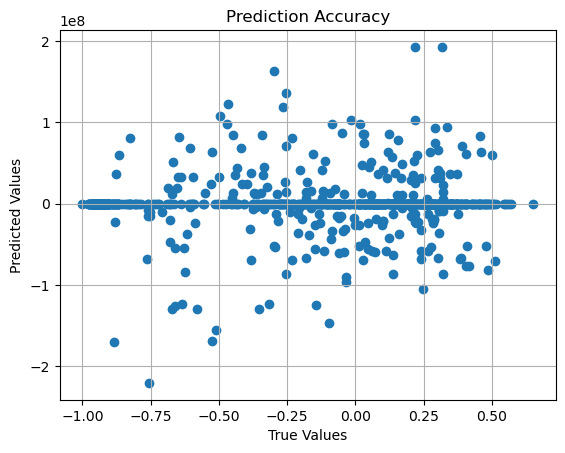

Computing feature coefficients...
Getting feature names...
Done. Retrieved 2604 feature names.
Done.
Top 10 features:                              feature   coefficient  abs_coefficient
1699             num__S2403_C02_003E  5.293660e+09     5.293660e+09
26                  num__B02001_001E  4.781786e+09     4.781786e+09
24    num__partisan_temp_change_prev  3.323601e+09     3.323601e+09
1513             num__S2401_C01_030E  3.292881e+09     3.292881e+09
1023             num__S2101_C04_015E  3.081459e+09     3.081459e+09
1018             num__S2101_C04_014E  3.068404e+09     3.068404e+09
547              num__S1501_C01_036E  2.773039e+09     2.773039e+09
1323             num__S2201_C05_033E  2.490936e+09     2.490936e+09
1863             num__S2501_C03_006E  2.377099e+09     2.377099e+09
688              num__S1501_C03_029E  2.352291e+09     2.352291e+09
228              num__S0101_C03_028E  2.348812e+09     2.348812e+09
1877             num__S2501_C02_009E  2.223468e+09     2.223468e+0

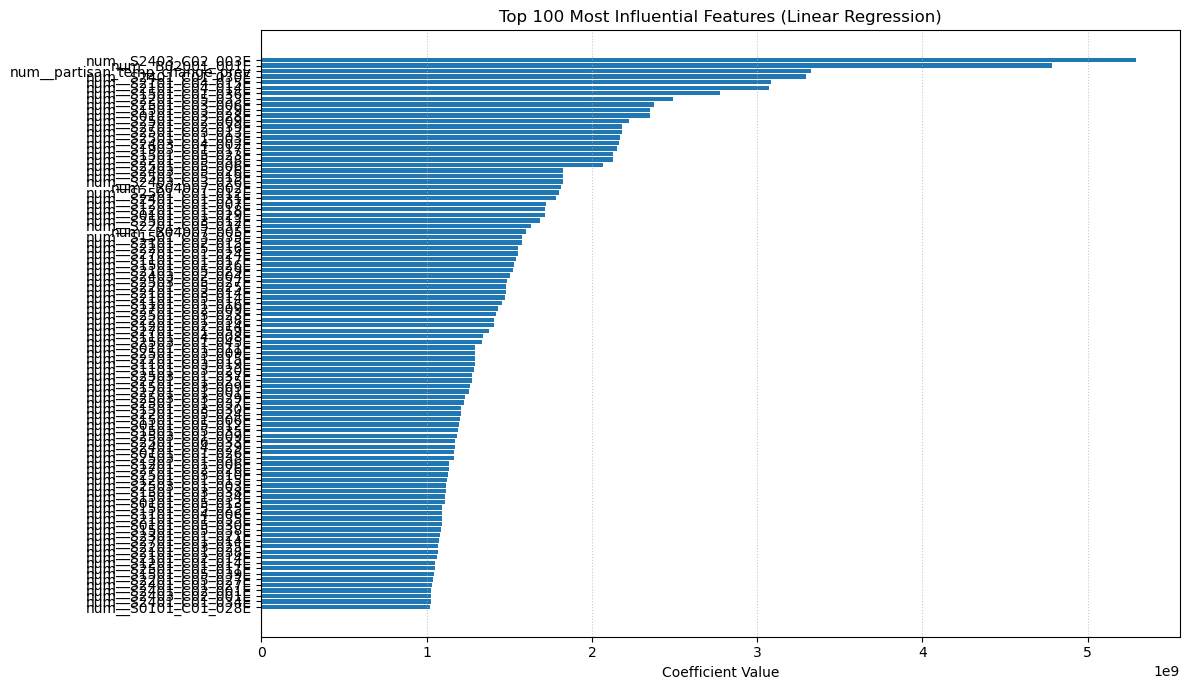

Processing year 2020...
Processing office US_House...
Making features and target...
Done.
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 2.2533189652193404e+16
R2 Score: -9.004435178752277e+16
Plotting accuracy...
Done.


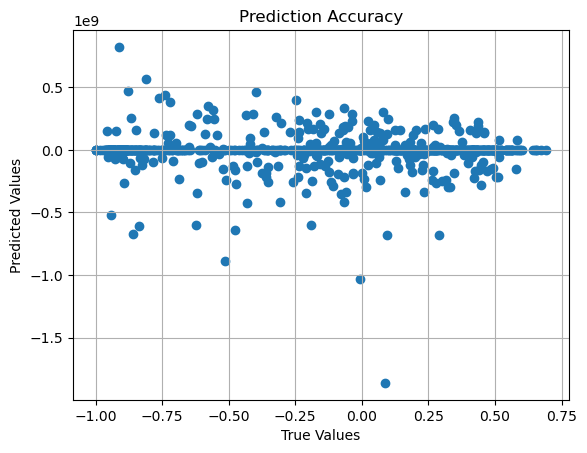

Computing feature coefficients...
Getting feature names...
Done. Retrieved 2606 feature names.
Done.
Top 10 features:                                  feature   coefficient  abs_coefficient
27                      num__B02001_002E  7.137133e+10     7.137133e+10
21    num__registered_voters_change_prev  3.824800e+10     3.824800e+10
28                      num__B02001_003E  3.628517e+10     3.628517e+10
482                  num__S1201_C06_003E  2.876596e+10     2.876596e+10
362                  num__S1201_C02_003E  2.678631e+10     2.678631e+10
751                  num__S1501_C05_036E  1.590308e+10     1.590308e+10
24        num__partisan_temp_change_prev  1.471167e+10     1.471167e+10
1047                 num__S2101_C04_015E  1.447567e+10     1.447567e+10
1046                 num__S2101_C04_014E  1.427572e+10     1.427572e+10
1832                 num__S2501_C01_032E  1.157989e+10     1.157989e+10
1668                 num__S2403_C01_003E  1.133952e+10     1.133952e+10
74                

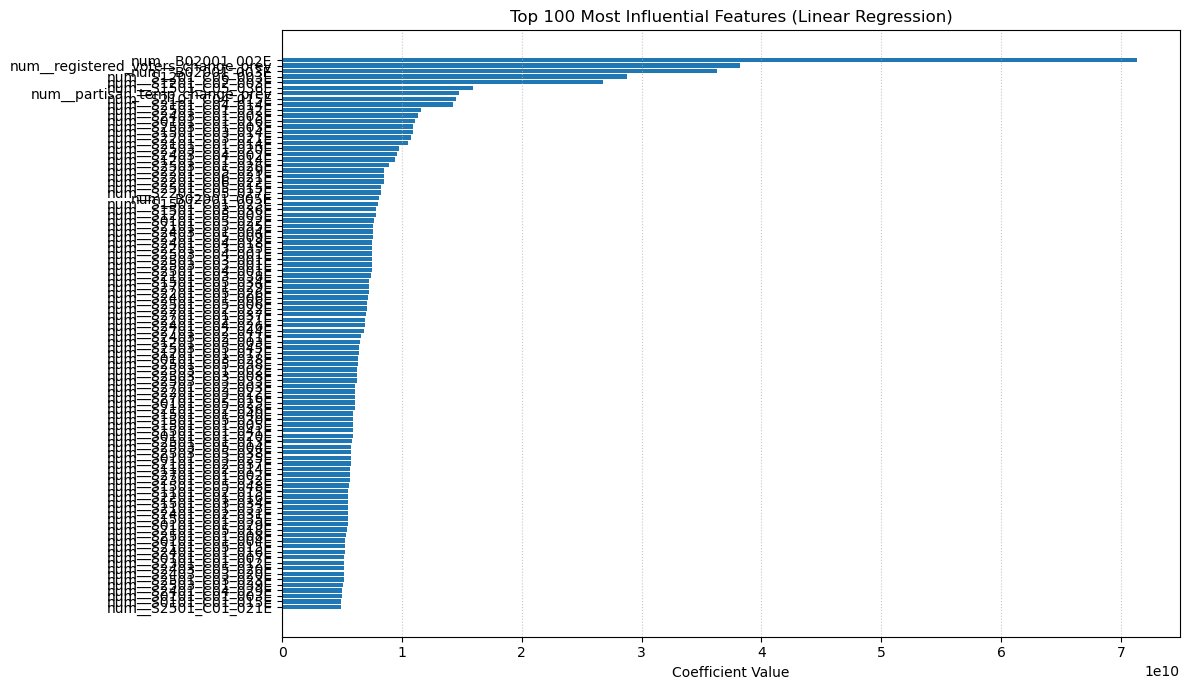

Processing year 2022...
Processing office US_House...
Making features and target...
Done.
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 1.7490652732577697e+20
R2 Score: -7.481024825880288e+20
Plotting accuracy...
Done.


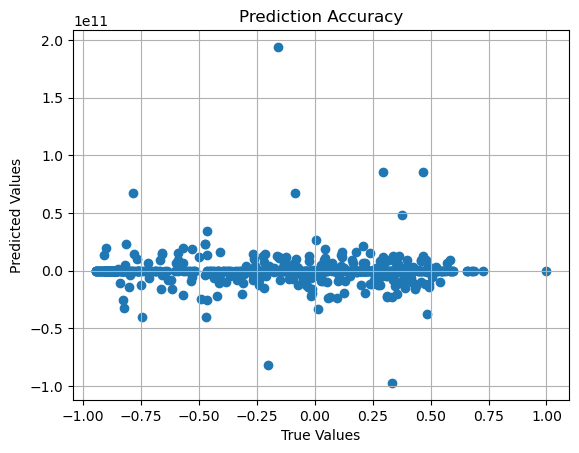

Computing feature coefficients...
Getting feature names...
Done. Retrieved 2610 feature names.
Done.
Top 10 features:                                         feature   coefficient  abs_coefficient
26    num__partisanship_lean_change_amount_prev  5.807169e+10     5.807169e+10
28                             num__B02001_002E  4.336579e+10     4.336579e+10
27                             num__B02001_001E  3.023636e+10     3.023636e+10
30                             num__B02001_004E  1.854120e+10     1.854120e+10
31                             num__B02001_005E  1.507750e+10     1.507750e+10
115                         num__S0101_C02_021E  1.154541e+10     1.154541e+10
993                         num__S2101_C02_032E  1.115737e+10     1.115737e+10
597                         num__S1501_C02_032E  1.086853e+10     1.086853e+10
1452                        num__S2301_C03_033E  9.677301e+09     9.677301e+09
2387                        num__S2503_C02_004E  9.628122e+09     9.628122e+09
802          

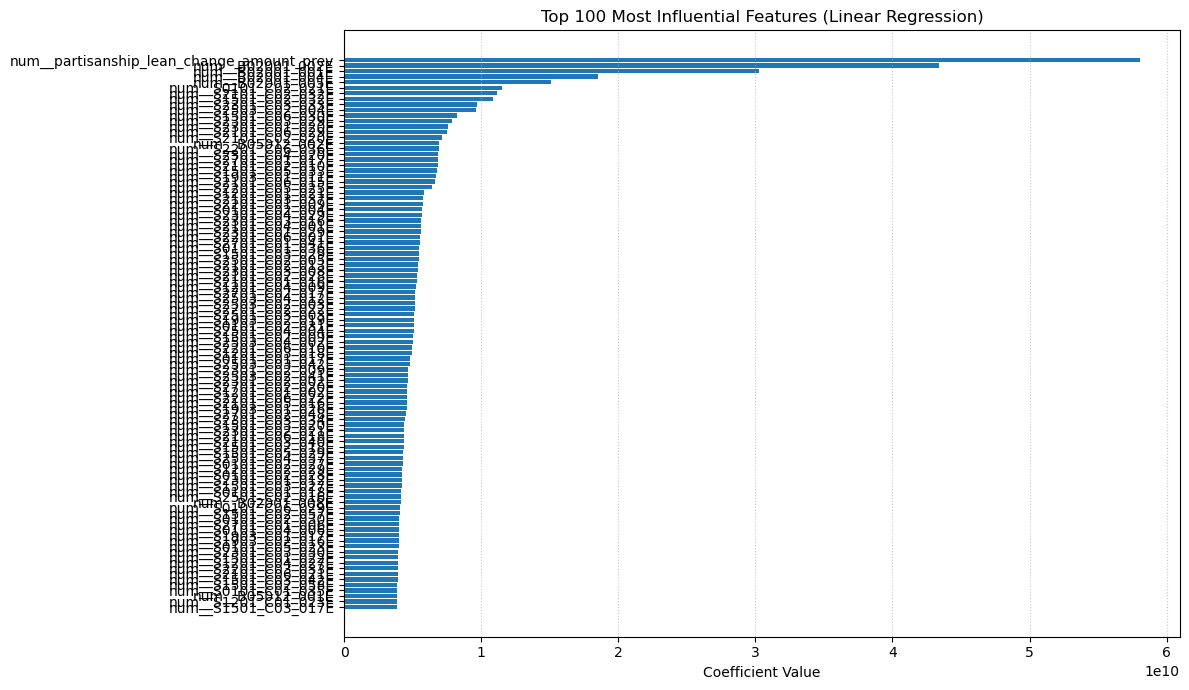

In [19]:
df_datasets = makeDatasets(YEARS, OFFICES)

top_features_lists = []

for year in YEARS:
    print(f'Processing year {year}...')
    
    for office in OFFICES:
        print(f'Processing office {office}...')
        
        df = df_datasets[year][office].copy()
        X, y = makeFeaturesTargets(df)

        # EXPERIMENTAL – these seem to be "must have" columns, at least rep_share_change_prev.
        X = X.drop(columns=[
            'rep_share_prev', 'dem_share_prev', 'oth_share_prev',
            'rep_share_change_prev', 'dem_share_change_prev', 'oth_share_change_prev',
        ])

        model, X_train, X_test, y_train, y_test, numeric_cols = fitModel(X, y)
        y_pred = makePredictions(X_test, model)
        
        mse = mean_squared_error(y_test, y_pred)
        print("Mean Squared Error:", mse)

        r2 = model.score(X_test, y_test)
        print("R2 Score:", r2)
        
        plt = plotAccuracy(y_test, y_pred)
        # plt.close()
        plt.show()
        
        top_features = featureCoeff(model)
        print(f'Top 10 features: {top_features[:20]}')

        top_features_lists.append(top_features['feature'].tolist())
        
        plt = plotFeatureCoeff(top_features)
        # plt.close()
        plt.show()

#### Use only top_n features
Train from scratch on the top features detected from above steps

In [13]:
# Merge top features from cycles
top_features_all = mergeTopFeatures(top_features_lists)
print(f'Num top features: {len(top_features_all)}')

top_features_all = top_features_all[:150]

Creating common top features...
Done.
Num top features: 7


In [14]:
# Remove certain features by name
if 'rep_share_change_prev' in top_features_all:
    top_features_all.remove('rep_share_change_prev')
if 'dem_share_change_prev' in top_features_all:
    top_features_all.remove('dem_share_change_prev')
if 'oth_share_change_prev' in top_features_all:
    top_features_all.remove('oth_share_change_prev')

# top_n_features_all = top_features_all[:TOP_N_FEATURES]

print(f'Top feature count: {len(top_features_all)}')
print(f'Top 10 features: {top_features_all[:10]}')

Top feature count: 7
Top 10 features: ['num__partisan_temp_prev', 'cat__partisanship_lean_curr_neutral', 'cat__partisanship_lean_prev_strong democrat', 'num__S2201_C03_025E', 'num__S1501_C01_036E', 'num__S1501_C03_050E', 'num__dem_votes_change_prev']


#### Aggregate Historical Training
Do we have data leakage here? Maybe not, if we train on historical data and
<br>run a separate test on newer data in a following step. Say, here we
train 2018-2022, <br>and then in another cell test 2024 on the same model

In [9]:
# Later in the notebook we pull 2024 data, which does not include the columns
# below for 2018, 2020, and 2022. If these columns are left in, errors are
# thrown when processing 2024 data. This must be done at this step, since
# the model is being trained here.

# When using ALL features, some columns are not present in 2024 and must be removed
# missing_2024_cols = ['S1101_C03_014E', 'S1101_C02_014E', 'S1101_C04_014E']
missing_2024_cols = False

df_datasets = makeDatasets(YEARS, OFFICES, missing_2024_cols)

dfs = []
for year in YEARS:
    print(f'Processing year {year}...')
    for office in OFFICES:
        print(f'Processing office {office}...')
        dfs.append(df_datasets[year][office].copy())
        
df = pd.concat(dfs, axis=0, ignore_index=True)
X, y = makeFeaturesTargets(df)

# X = X[[col for col in top_features_all if col in X.columns]]

X = X[top_features_all]

model, X_train, X_test, y_train, y_test, numeric_cols = fitModel(X, y)
y_pred = makePredictions(X_test, model)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = model.score(X_test, y_test)
print("R2 Score:", r2)

plt = plotAccuracy(y_test, y_pred)
plt.show()

top_features = featureCoeff(model)
print(f'Top 10 features: {top_features[:10]}')

plt = plotFeatureCoeff(top_features)
plt.show()

Making datasets...
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Done.
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Making features and target...
Done.
Fitting model...


ValueError: Found array with 0 feature(s) (shape=(8946, 0)) while a minimum of 1 is required by LinearRegression.

#### Individual Cycle Future Prediction
This functionality requires objects and variables initiatlized in previous cells, including <code>model</code>
<br>and <code>numeric_cols</code>. When using aggregated cycle data, the model should be trained on historical
<br>elections only, previous to the upcoming election that is being predicted.

In [ ]:
year = '2022'
office = 'US_House'

df_datasets = makeDatasets([year], [office])

df = df_datasets[year][office].copy()
X, y = makeFeaturesTargets(df)

X = X[[col for col in top_features_all if col in X.columns]]

# X = X[top_features_all]

y_pred = makePredictions(X, model)

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

r2 = model.score(X_test, y_test)
print("R2 Score:", r2)

plt = plotAccuracy(y, y_pred)
plt.show()

top_features = featureCoeff(model, numeric_cols)
print(f'Top 10 features: {top_features[:10]}')

plt = plotFeatureCoeff(top_features)
plt.show()